# Understand and Model Cryptocurrencies Volatility Using GARCH Variants

I had a difficult time to understand GARCH and its variants. In this post, I am going to show you what I have come across while learning and experimenting on this topic. If you are well-versed in this area, please do keep reading and point out the mistakes in this piece. Hopefully, it will help someone in the future.

We are going to use BTCUSD as an example for the rest of this article. Feel free to try the following techniques on other cryptocurrencies pairs. Shoot me a message on [Patreon](https://www.patreon.com/0xboz), [Discord](https://discord.gg/JHt7UQu) or [Twitter](https://twitter.com/0xboz) and let me know what you have found so far.

You might also like to [sign up for my newsletter](http://eepurl.com/gxmy39) and stay tuned with the latest articles.

## Data

First of all, let us get BTCUSD minute data. Due to the sheer size of the data, you can scale down the time window if the code takes too long.

In [1]:
from catalyst.api import symbol, record
from catalyst import run_algorithm

import pandas as pd

trading_pair = 'btc_usd'
frequency = 'minute'
exchange = 'bitfinex'
start = '2017-4-1'
end = '2019-4-1'
capital_base = 1000
quote_currency = trading_pair.split('_')[1]

def initialize(context):
    context.asset = symbol(trading_pair)

def handle_data(context, data):
    
    # The last known price and volume of current date/minute and the day/minute before
    if frequency == 'daily':        
        price = data.current(context.asset, 'price')
        volume = data.current(context.asset, 'volume')
    elif frequency == 'minute':        
        price = data.current(context.asset, 'price')
        volume = data.current(context.asset, 'volume')

    record(price=price, volume=volume)
  
if __name__ == '__main__':   
    perf = run_algorithm(capital_base=capital_base,
                         data_frequency=frequency,
                         initialize=initialize,
                         handle_data=handle_data,                      
                         exchange_name=exchange,
                         quote_currency=quote_currency,
                         start=pd.to_datetime(start, utc=True),
                         end=pd.to_datetime(end, utc=True))

[2019-07-16 21:15:59.656855] INFO: run_algo: Catalyst version 0.5.21
[2019-07-16 21:15:59.657737] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-07-16 21:16:02.659480] INFO: run_algo: running algo in backtest mode
[2019-07-16 21:16:02.919228] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2019-07-16 21:40:13.256440] INFO: Performance: Simulated 731 trading days out of 731.
[2019-07-16 21:40:13.256909] INFO: Performance: first open: 2017-04-01 00:00:00+00:00
[2019-07-16 21:40:13.257302] INFO: Performance: last close: 2019-04-01 23:59:00+00:00


Once it is done, we will have 2-year of BTCUSD minute data from [Bitfinex](https://www.bitfinex.com/).

Now, it is time to resample our data and perform a few simple calculations.

In [2]:
import numpy as np
# Resample to minute data
m_df = pd.DataFrame(perf.loc[:, ['price', 'volume']], index=perf.index).resample('T', closed='left', label='left').mean().copy()
m_df.index.name = 'timestamp'
m_df['log_price'] = np.log(m_df.price)
m_df['return'] = m_df.price.pct_change().dropna()
m_df['log_return'] = m_df['log_price'] - m_df['log_price'].shift(1)

# Calculate squared log return
m_df['squared_log_return'] = np.power(m_df['log_return'], 2)

# Scale up 100x
m_df['return_100x'] = np.multiply(m_df['return'], 100)
m_df['log_return_100x'] = np.multiply(m_df['log_return'], 100)

m_df.head()

,price,volume,log_price,return,log_return,squared_log_return,return_100x,log_return_100x
timestamp,,,,,,,,
2017-04-01 00:01:00+00:00,1081.5,6.752945,6.986104,NaN,NaN,NaN,NaN,NaN
2017-04-01 00:02:00+00:00,1081.4,3.928597,6.986012,-0.000092,-0.000092,8.550413e-09,-0.009246,-0.009247
2017-04-01 00:03:00+00:00,1081.7,2.540370,6.986289,0.000277,0.000277,7.693949e-08,0.027742,0.027738
2017-04-01 00:04:00+00:00,1081.6,16.532780,6.986197,-0.000092,-0.000092,8.547253e-09,-0.009245,-0.009245
2017-04-01 00:05:00+00:00,1082.2,15.992445,6.986751,0.000555,0.000555,3.075589e-07,0.055473,0.055458


You may wonder why we need scale up 100 times for simple returns and log returns. This is because ```ARCH``` Python package might run into convergence issues. Do not worry, and I will show you another way around without scaling up.

## Volatility
Since there is a general consense that the volatility is more sticky than the price in financial market, much of the effort has been allocated to study the models of volatility. Before we can jump into any fancy models and math, let us define what is volatility and how to caculate it.

The following is cited from [Wikipedia](https://en.wikipedia.org/wiki/Volatility_(finance)).
> In finance, volatility (symbol σ) is the degree of variation of a trading price series over time as measured by the standard deviation of logarithmic returns.

We can arrive at the mathematical definiton with ease.
\begin{equation*}
\sigma = \sqrt{\frac{1}{n-1}\sum_{i=1}^n(\bar{r} - r_i)^2}
\end{equation*}

Where,   
$\sigma$ is volatility,      
$\bar{r}$ is mean log return,  
$r_i$ is the log return at time i,  
$n$ is the number of log return observations.

## Daily Volatility & Variance

A simple volatility calculated from a range of the sample time series is not that useful when we need to implement more advanced models. We are more inclined to estimate the volatility/variance for a certain time interval.

> Equally as important as the forecast methodology is the proxy of variance that one measures performance against.

One common way is to use daily squared log return $r_d^2$ as a proxy of eastimating the true variance. Let us resample the data by day and calculate daily squared log returns.

In [3]:
# Resample to daily data
d_df = pd.DataFrame(m_df.loc[:, ['price', 'volume']], index=m_df.index).resample('D', closed='left', label='left').mean().copy()
d_df['log_price'] = np.log(d_df.price)
d_df['return'] = d_df.price.pct_change().dropna()
d_df['log_return'] = d_df['log_price'] - d_df['log_price'].shift(1)
d_df['squared_log_return'] = np.power(d_df['log_return'], 2)

# Scale up 100x
d_df['return_100x'] = np.multiply(d_df['return'], 100)
d_df['log_return_100x'] = np.multiply(d_df['log_return'], 100)

d_df.head()

,price,volume,log_price,return,log_return,squared_log_return,return_100x,log_return_100x
timestamp,,,,,,,,
2017-04-01 00:00:00+00:00,1086.633148,11.808373,6.990839,NaN,NaN,NaN,NaN,NaN
2017-04-02 00:00:00+00:00,1095.521806,14.183194,6.998986,0.008180,0.008147,0.000066,0.818000,0.814672
2017-04-03 00:00:00+00:00,1138.100972,21.106648,7.037116,0.038867,0.038130,0.001454,3.886656,3.813028
2017-04-04 00:00:00+00:00,1143.858542,14.609319,7.042163,0.005059,0.005046,0.000025,0.505893,0.504617
2017-04-05 00:00:00+00:00,1130.486875,15.630853,7.030404,-0.011690,-0.011759,0.000138,-1.168997,-1.175883


However, the downside of this method is incredibly noisy. 

Another commonly accepted approach is called *realized volatility (RV)*, coined by Bollershev. Basically, the summation of squared intraday returns aggregated to the daily level can be used to measure that day's variance. For instance, if we have BTCUSD minute data, its daily variance can be estimated as follows:

$$ \begin{equation*}
RV_{d_{j+1}} = \sum_{i = 1}^{1440} r_{t_{i + 1440(j+1)}}^2 
\end{equation*} $$

Here is how we implement it in Python.

In [4]:
d_df['realized_variance_1min'] = pd.Series(m_df.loc[:, 'squared_log_return'], index=perf.index).resample('D', closed='left', label='left').sum().copy()
d_df['realized_volatility_1min'] = np.sqrt(d_df['realized_variance_1min'])
d_df.head()

,price,volume,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1min,realized_volatility_1min
timestamp,,,,,,,,,,
2017-04-01 00:00:00+00:00,1086.633148,11.808373,6.990839,NaN,NaN,NaN,NaN,NaN,0.000645,0.025388
2017-04-02 00:00:00+00:00,1095.521806,14.183194,6.998986,0.008180,0.008147,0.000066,0.818000,0.814672,0.000757,0.027519
2017-04-03 00:00:00+00:00,1138.100972,21.106648,7.037116,0.038867,0.038130,0.001454,3.886656,3.813028,0.000751,0.027406
2017-04-04 00:00:00+00:00,1143.858542,14.609319,7.042163,0.005059,0.005046,0.000025,0.505893,0.504617,0.000510,0.022578
2017-04-05 00:00:00+00:00,1130.486875,15.630853,7.030404,-0.011690,-0.011759,0.000138,-1.168997,-1.175883,0.000493,0.022203


Another common interval to calculate RV is 5-min data interval. Of course, the formula mentioned above will be re-written like this.

$$ \begin{equation*}
RV_{d_{j+1}} = \sum_{i = 1}^{288} r_{t_{i + 288(j+1)}}^2 
\end{equation*} $$

In [5]:
# Resample to 5-min data
five_min_df = pd.DataFrame(m_df.loc[:, ['price', 'volume']], index=m_df.index).resample('5T', closed='left', label='left').mean().copy()
five_min_df['log_price'] = np.log(five_min_df.price)
five_min_df['log_return'] = five_min_df['log_price'] - five_min_df['log_price'].shift(1)
five_min_df['squared_log_return'] = np.power(five_min_df['log_return'], 2)
five_min_df.head()

,price,volume,log_price,log_return,squared_log_return
timestamp,,,,,
2017-04-01 00:00:00+00:00,1081.55,7.438673,6.986150,NaN,NaN
2017-04-01 00:05:00+00:00,1081.98,19.154190,6.986548,0.000397,1.580051e-07
2017-04-01 00:10:00+00:00,1082.96,2.362552,6.987453,0.000905,8.196350e-07
2017-04-01 00:15:00+00:00,1083.78,2.617299,6.988210,0.000757,5.728938e-07
2017-04-01 00:20:00+00:00,1083.86,2.761562,6.988284,0.000074,5.448358e-09


In [6]:
d_df['realized_variance_5min'] = pd.Series(five_min_df.loc[:, 'squared_log_return'], index=perf.index).resample('D', closed='left', label='left').sum().copy()
d_df['realized_volatility_5min'] = np.sqrt(d_df['realized_variance_5min'])
d_df.head()

,price,volume,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1min,realized_volatility_1min,realized_variance_5min,realized_volatility_5min
timestamp,,,,,,,,,,,,
2017-04-01 00:00:00+00:00,1086.633148,11.808373,6.990839,NaN,NaN,NaN,NaN,NaN,0.000645,0.025388,0.000435,0.020851
2017-04-02 00:00:00+00:00,1095.521806,14.183194,6.998986,0.008180,0.008147,0.000066,0.818000,0.814672,0.000757,0.027519,0.000434,0.020839
2017-04-03 00:00:00+00:00,1138.100972,21.106648,7.037116,0.038867,0.038130,0.001454,3.886656,3.813028,0.000751,0.027406,0.000704,0.026524
2017-04-04 00:00:00+00:00,1143.858542,14.609319,7.042163,0.005059,0.005046,0.000025,0.505893,0.504617,0.000510,0.022578,0.000458,0.021391
2017-04-05 00:00:00+00:00,1130.486875,15.630853,7.030404,-0.011690,-0.011759,0.000138,-1.168997,-1.175883,0.000493,0.022203,0.000380,0.019500


Some simple configurations for our charts.

In [38]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
# Increase chart resolution
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 4.0)
sns.mpl.rcParams['savefig.dpi'] = 150
sns.mpl.rcParams['font.family'] = 'serif'
sns.mpl.rcParams['font.size'] = 12
sns.mpl.rcParams['lines.linewidth'] = 1.3

While we are at it, let us plot those three and take a look.

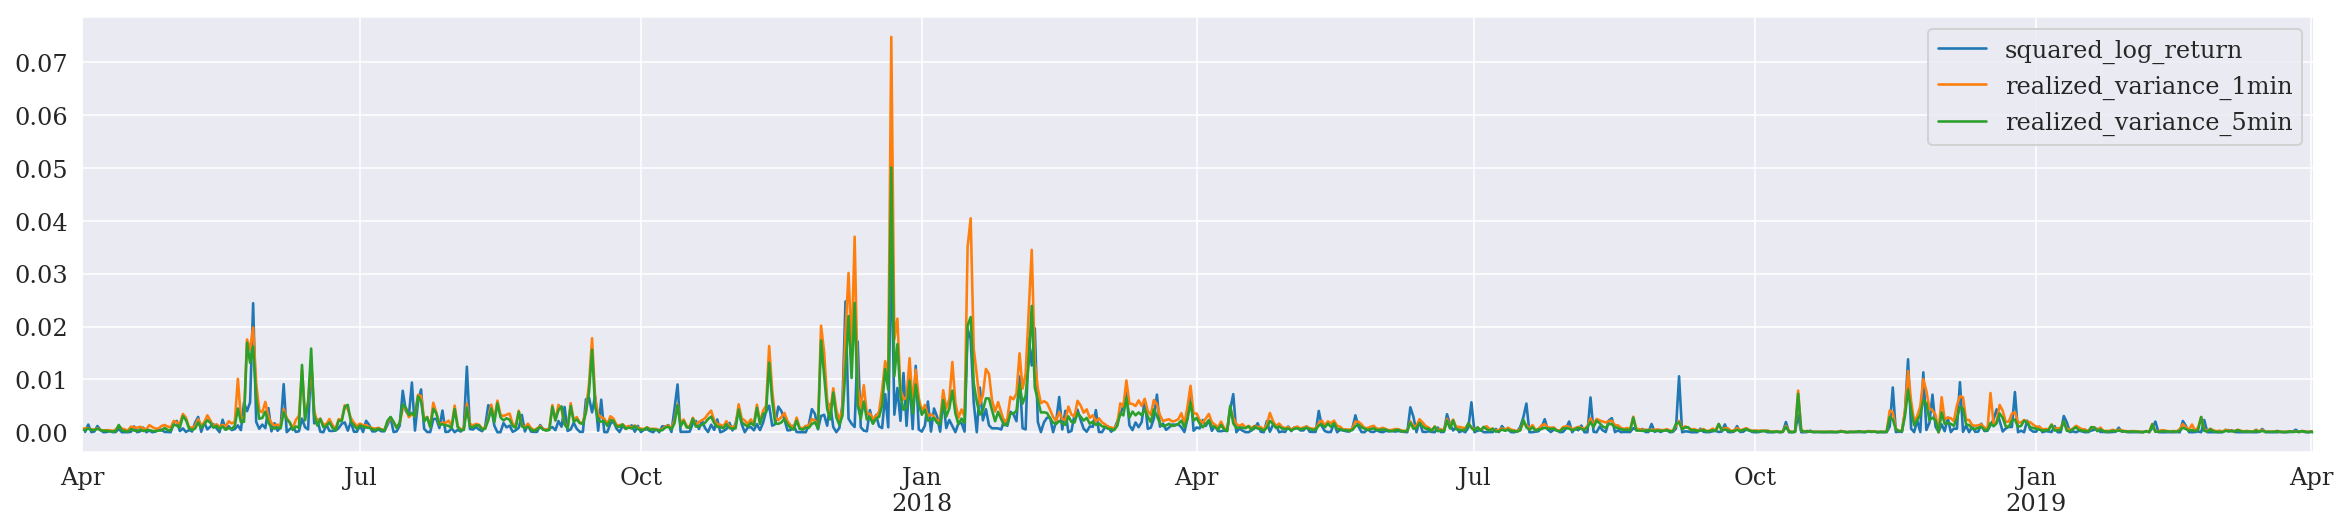

In [39]:
ax1 = d_df.loc[:, ['squared_log_return', 'realized_variance_1min', 'realized_variance_5min']].plot()
# Good reference to remove x/y axis label
# https://stackoverflow.com/questions/40705614/hide-axis-label-only-not-entire-axis-in-pandas-plot
ax1.xaxis.label.set_visible(False)

As expected, the realized variance plots are visually smoother than squared log return plot, especially around January 2018.

## Evaluation
There are three commonly accepted criteria to evalute a variety of models in financial area - Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE) and Root Mean Square Error (RMSE). 

#### Mean Absolute Error (MAE)
$$ \begin{equation*}
MAE = \frac{\sum_{i=1}^n|y_i - x_i|}{n}
\end{equation*} $$

#### Mean Absolute Percentage Error (MAPE)
$$ \begin{equation*}
MAPE = \frac{100}{n}\sum_{t=1}^n|\frac{A_t - F_t}{A_t}|
\end{equation*} $$

#### Root Mean Square Error (RMSE)
$$ \begin{equation*}
RMSE = \sqrt{\frac{\sum_{i=1}^n(x_{obs,i} - y_{model,i})^2}{n}}
\end{equation*} $$ 

By definition, it is quite obvious that the smaller values calculated by those methods, the better performance of our model of interest. It is fairly easy to implement those criteria in Python as well.

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluation(observation, forecast):
    """
    :type pandas series
    :return the results of MAE, MAPE and RMSE, respectively
    """
    first_valid_date = forecast.first_valid_index()
    mae_error = mae(observation.loc[first_valid_date:, ], forecast.loc[first_valid_date:, ])
    mape_error = mape(observation.loc[first_valid_date:, ], forecast.loc[first_valid_date:, ])
    rmse_error = rmse(observation.loc[first_valid_date:, ], forecast.loc[first_valid_date:, ])   
    return mae_error, mape_error, rmse_error

def evaluate(pd_dataframe, observation, forecast):
    """
    :params
    :pd_dataframe pandas dataframe
    :observation column name of expected values
    :forecast column name of forecasted values
    :return the results of MAE, MAPE and RMSE, respectively
    """
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot()
    ax.xaxis.label.set_visible(False)
    
    return mae_error, mape_error, rmse_error

In [ ]:
y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
mape(y_true, y_pred)

<div class="notice">
  <p>Exponentially Weighted Moving Average (EWMA) is simply introduced here to help understanding ARCH. However, we not going for a deep dive other than deriving a few equations. You may skip this session.</p>
</div>

## Exponentially Weighted Moving Average
One simple way of estimating future volatility is to use historical weighted volatilities. The assumption is that the further we go back in time, the less impact the previous volatility has on the future. Since this method simply chooses a constant rate over time, it is hard to miss that exponential decreasing pattern on the chart.

Before we can move forward, we need to simplify the equation from the volatility definition. When we have a larger number of observations and relatively smaller time window (i.e. daily data), it is safe to assume $n-1 \approx n$ and $(\bar{r} - r_i)^2 \approx r_i^2$. If we take it a bit further by squaring both sides, we get this.

$$ \begin{equation*}
\sigma_t^2 = \frac{1}{n}\sum_{i=1}^nr_{t-i}^2
\end{equation*} $$

<div class="notice--info">
  <p>The added subscript $t$ means today's volatility.</p>
</div>

In other words, the variance of log return is the average of all squared log returns within the observation window $n$. However, this form simply allows the even contribution from all previous log returns. The next step is to implement ```exponentially weighted``` approach by introducing lambda $\lambda$.

$$ \begin{equation*}
\sigma_t^2 = \frac{\lambda^0r_{t-1}^2 + \lambda^1r_{t-2}^2 + \lambda^2r_{t-3}^2 + ... + \lambda^{n-1}r_{t-n}^2}{\lambda^0 + \lambda^1 + \lambda^2 + ... + \lambda^{n-1}}
\end{equation*} $$

The above equation can also be written like this.

$$ \begin{equation*}
\sigma_t^2 = \sum_{i=1}^n\alpha_ir_{t-i}^2
\end{equation*} $$

$$ \begin{equation*}
\sum_{i=1}^n\alpha_i = 1 
\end{equation*} $$

$$ \begin{equation*}
\alpha_{i+1} = \lambda\alpha_i
\end{equation*} $$

## Autoregressive Conditional Heteroskedasticity (ARCH)
[In our previous posts](https://0xboz.github.io/blog/how-to-create-arima-model-forecasting-btc-usd-in-python-part-2/), we have developed autoregressive models for univariate time series data that is stationary (AR), has a trend (ARIMA), and has a seasonal component (SARIMA). All of these models assume the data has a constant variance over time. However, financial markets and crypto trading data are exposed to consistent changes of the variance in time series - volatility.

Moderate changes in variance can be easily dealt with the power transformation, such as natural log and Box-Cox transformation. When the variance is largely time-dependent, the autoregressive process is introduced to treat the data.

> In a nutshell, ARCH models the variance at a time step as a function of the residual errors from a mean process (e.g. a zero mean). 

In other words, AR model is applied to the variance of a time series. 

<div class="notice--info">
  <p>ARCH is only applicable where the time series is stationary, other than the change in variance, meaning it does not have a trend or seasonal component. </p>
</div>

Similar to the equation mentioned in EWMA, $\alpha_0$, $\alpha_1$ ... and $\alpha_q$ are considered as the parameters of the model instead of the weights.

\begin{equation*}
Var(r_t | r_{t-1}, r_{t-2}, ..., r_{t-p}) 
= \alpha_0 + \alpha_1r_{t-1}^2 + \alpha_2r_{t-2}^2 + ... + \alpha_pr_{t-p}^2
\end{equation*}

> ```p```: The number of lag residual errors to include in the ARCH model.

Normally, researchers will start with ARIMA model to select the best combination of the parameters based on the lowest score of AIC, BIC or HQIC as we have discussed in a [previous post](https://0xboz.github.io/blog/how-to-create-arima-model-forecasting-btc-usd-in-python-part-2/).

> The configuration for an ARCH model is best understood in the context of ACF and PACF plots of the variance of the time series. This can be achieved by subtracting the mean from each observation in the series and squaring the result, or just squaring the observation if you’re already working with white noise residuals from another model.  - [Jason Brownlee at Machine Learning Mastery](https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/)

For the sake of this post, let us assume the mean log return is zero over time and run autocorrelations on those squared observations.

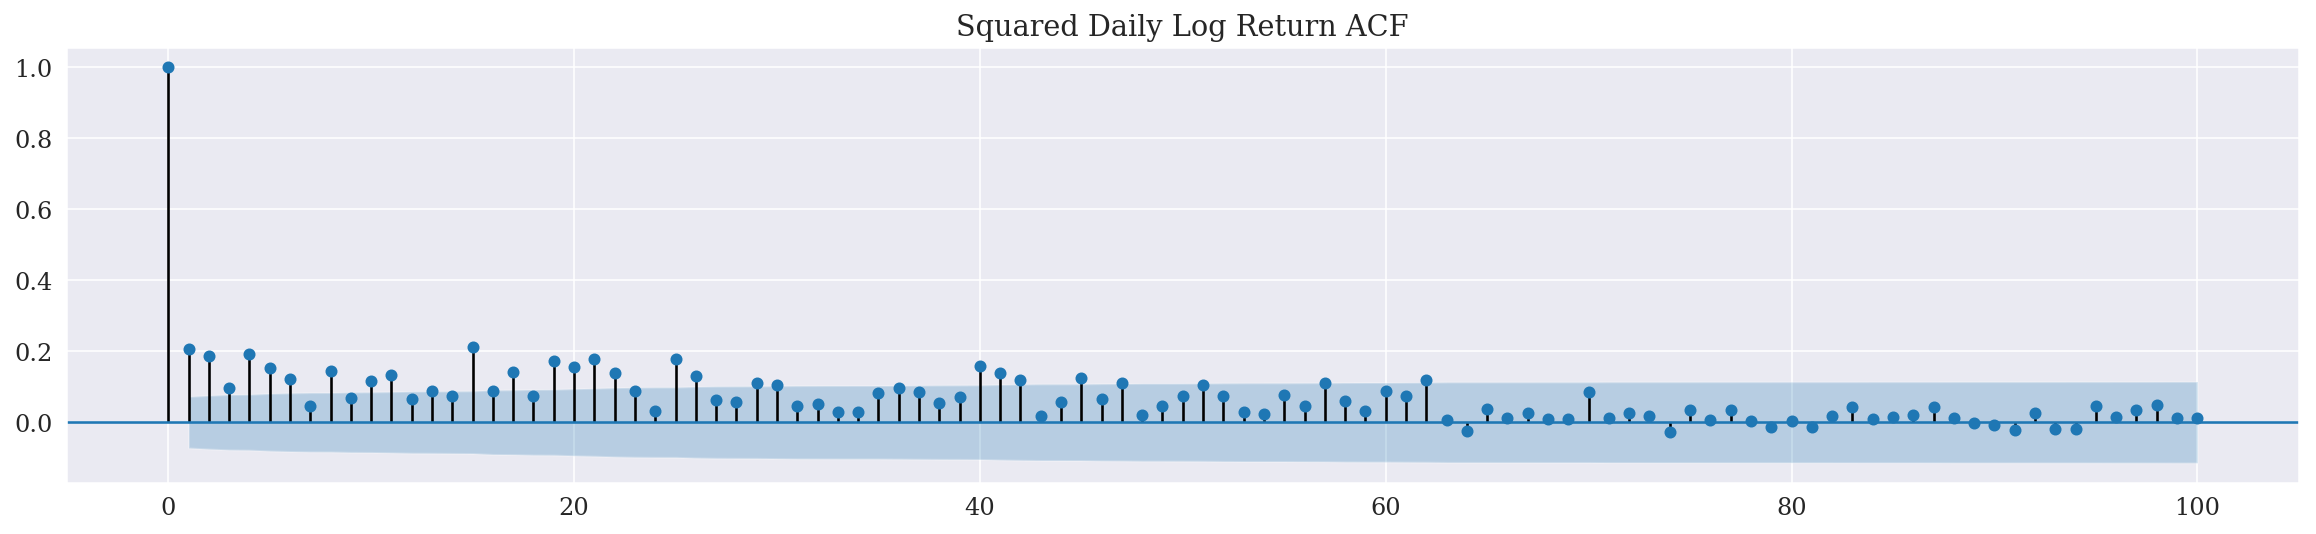

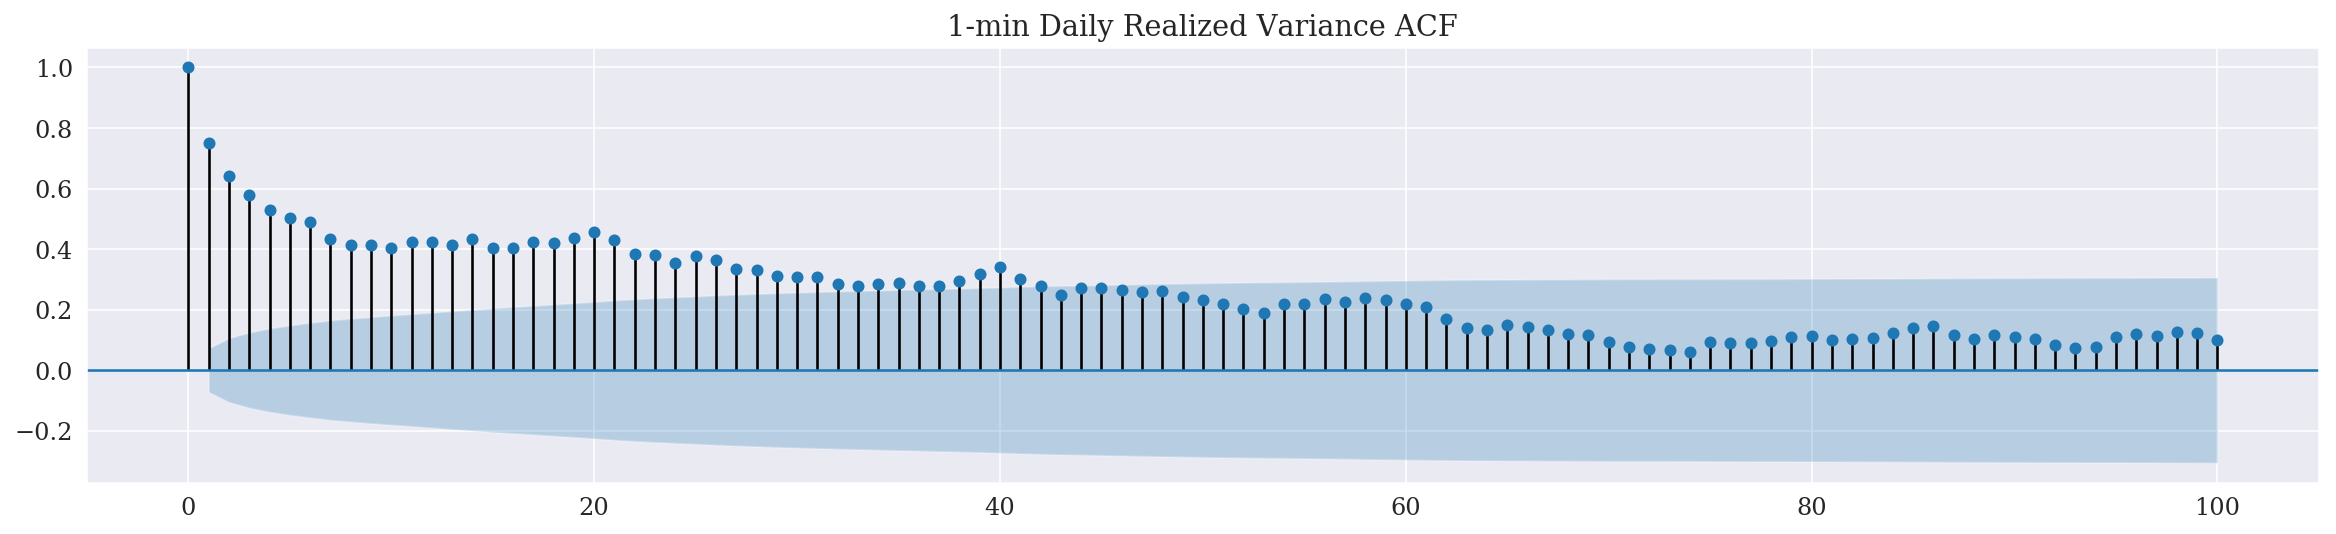

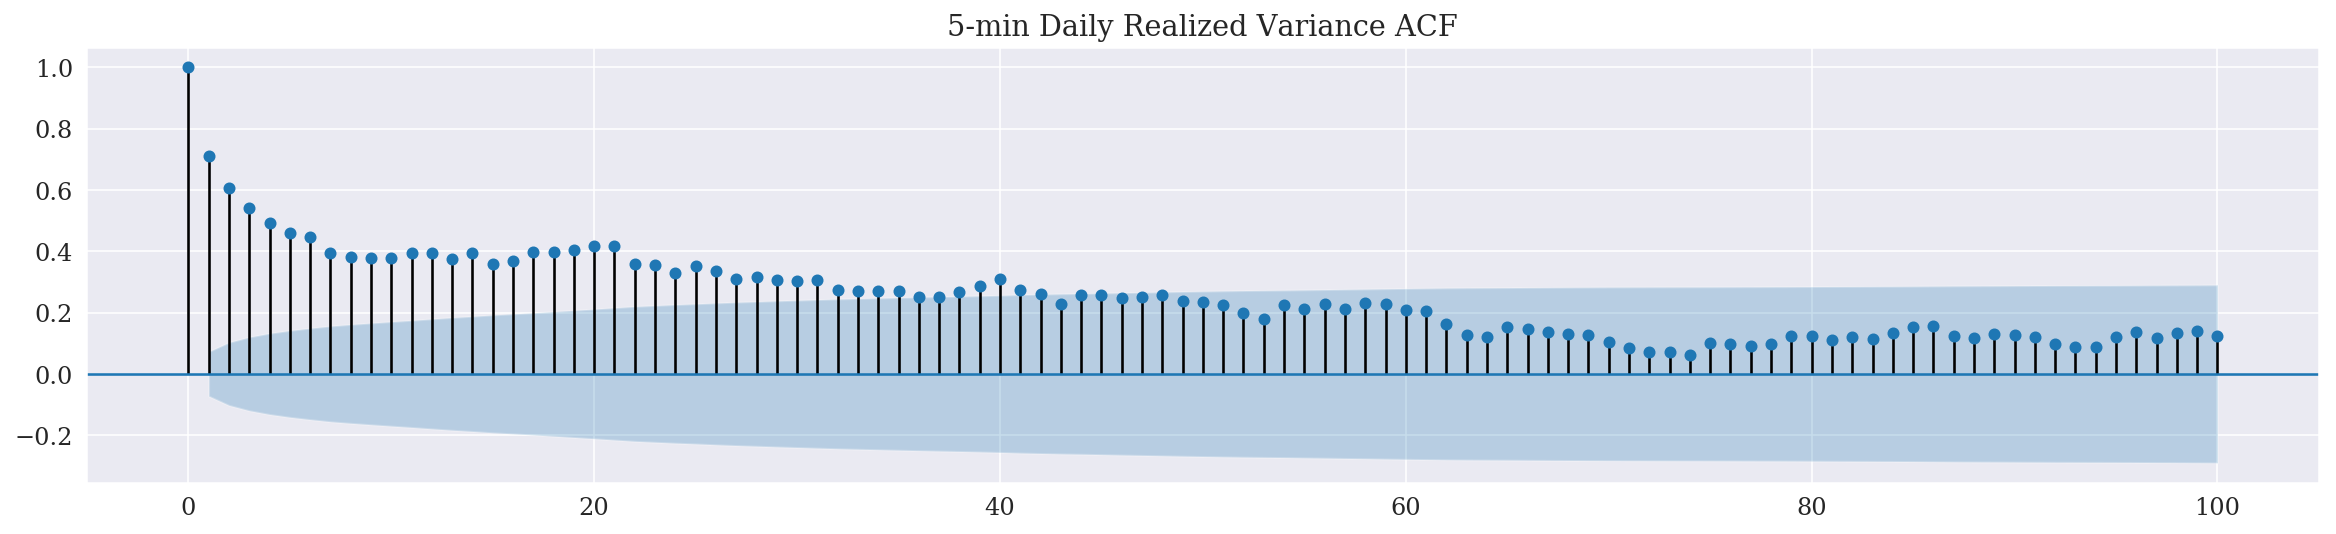

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(d_df['squared_log_return'][1:], lags=100, title='Squared Daily Log Return ACF')
_ = plot_acf(d_df['realized_volatility_1min'][1:], lags=100, title='1-min Daily Realized Variance ACF')
_ = plot_acf(d_df['realized_volatility_5min'][1:], lags=100, title='5-min Daily Realized Variance ACF')

In case of squared log return, we have a positive correlation up to 62 lag time steps. On the other hand, the realized variance (both 1-min and 5-min) ACF correlograms have showed a positive correlation till 46 lag time steps. Since realized variance is generally considered as a more accurate estimate of the true variance, we are going to set the lag as 46.

Or is it? I have tried this lag. However, the evaluation errors are much larger than those using ARCH package default value. I could not figure out why. If you are having the same issue, please do let me know. And of course, if you know the solution, I am all ears! 

## Generalized Autoregressive Conditional Heteroskedasticity (GARCH)

Notice that we have only used squared log returns to estimate the variance so far. If we take one step further by incorporating previous variances into the model, we will get the following.

$$ \begin{equation*}
Var(y_t | y_{t-1}, y_{t-2}, ..., y_{t-q}, \sigma_{t-1}, \sigma_{t-2}, ..., \sigma_{t-p}) 
= \alpha_0 + \alpha_1y_{t-1}^2 + \alpha_2y_{t-2}^2 + ... + \alpha_py_{t-q}^2 + 
\beta_0 + \beta_1\sigma_{t-1}^2 + \beta_2\sigma_{t-2}^2 + ... + \beta_p\sigma_{t-p}^2
\end{equation*} $$

> $p$: The number of lag variances to include in the GARCH model.  
> $q$: The number of lag residual errors to include in the GARCH model.

<div class="notice--warning">
  <p>PAY ATTENTION TO NAME CONVENTIONS. $p$ in ARCH(p) specifies the number of lag residual errors, while $p$ in GARCH(p, q) is for the number of lag variances.</p>
</div>

### GARCH vs. EGARCH
Although there are thousands of academic papers and published books which focus on studying different volatility models in financial industry, we can find few studies to discuss the correlations between the existing forecasting models and cryptocurrencies markets. Interestingly, EGARCH seems to perform better than GARCH and its other variants over all, according to [Naimy](https://www.inderscienceonline.com/doi/abs/10.1504/IJMMNO.2018.088994) and [Zheng](https://medium.com/coinmonks/a-systematic-review-of-forecasting-the-cryptocurrency-volatility-using-garch-model-d1855c9779c).

Exponential Generalized Autoregressive Conditional Heteroscedasticity (EGARCH) is a variant of GARCH. It integrated the asymmetric influence on volatility from both positive and negative impacts by introducing natural log on the variable of interest. There was an empirical belief that the negative factors can perform stronger volatility than positive factors, even with the same absolute value. The practice of asymmetry volatility was further confirmed by the famous Leverage Effect Theory proposed by Black in 1976 "*Studies in Stock Price Volatility Change*". Negative values are allowed in EGARCH, while conditional variance is positive. 

In ```ARCH``` package, EGARCH variance dynamics are

$$ \begin{equation*}
\ln\sigma_{t}^{2}=\omega
+\sum_{i=1}^{p}\alpha_{i}
\left(\left|e_{t-i}\right|-\sqrt{2/\pi}\right)
+\sum_{j=1}^{o}\gamma_{j} e_{t-j}
+\sum_{k=1}^{q}\beta_{k}\ln\sigma_{t-k}^{2}
\end{equation*} $$

where $e_{t}=\epsilon_{t}/\sigma_{t}$

## ```ARCH``` Python Package

In [88]:
from arch import arch_model

[```ARCH```](https://github.com/bashtage/arch) is a package written in Python (with Cython and/or Numba used to improve performance). As discussed in [ARCH official document](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html), there are four types of forecasting schemes (basic, fixed window, rolling window and recursive forecasting) at our disposal. I am going to demonstrate how to implement 3 out of those 4 schemes via ARCH, GARCH and EGARCH.

In [91]:
model_in_sample = arch_model(d_df['log_return'][1:], mean='Zero', vol='ARCH', p=1, dist='t')
res_in_sample = model_in_sample.fit(disp='off')

/home/bo/Projects/learn_algo_trading/catalyst-venv/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


You might encounter an error message like the one above - "ConvergenceWarning". Recall we scale up 100x of the log return? This is because ARCH package cannot handle small numbers by defaut. We either scale up our data or re-adjust the default value.

In [92]:
# Scale up 100x
model_in_sample = arch_model(d_df['log_return_100x'][1:], mean='Zero', vol='ARCH', p=1, dist='t')
res_in_sample = model_in_sample.fit(disp='off')

Alternatively, we can pass in some options in the ```fit()``` function.

In [93]:
model_in_sample = arch_model(d_df['log_return'][1:], mean='Zero', vol='ARCH', p=1, dist='t')
# Pass in options
# 'ftol' is 1e-06 by defaut
# Re-adjust to 1e-01 for our data
res_in_sample = model_in_sample.fit(disp='off', options={'ftol': 1e-01})

Let us just stay with passing in ```ftol``` value for the rest of this tutorial. Feel free to experiment with the scaling up option.

#### Fixed Window Forecasting
We can use a fixed window forecasting scheme in ```ARCH``` package and see what happens.

> Fixed-windows forecasting uses data up to a specified date to generate all forecasts after that date.   

The nice part of this scheme is that we can pass the entire data set when initializing the model. We just need to provide the last observation timestamp when calling ```fit()``` function. The following ```forecast()``` function will, by default, produce forecasts after that timestamp.

We can create a simple function to run ARCH, GARCH and EGARCH all together.

In [96]:
def fixed_window_forecast(pd_dataframe):
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:
        mod = arch_model(pd_dataframe['log_return'][1:], mean='Zero', vol=model, dist='t')
        res = mod.fit(disp='off', last_obs=356, options={'ftol': 1e-01})
        forecasts = res.forecast()
        pd_dataframe['fixed_window_{}'.format(model)] = forecasts.variance['h.1']
        print('------------------------------------------------')
        print('Fixed Window Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'realized_variance_1min', 'fixed_window_{}'.format(model))

------------------------------------------------
Fixed Window Forcasting ARCH
Mean Absolute Error (MAE): 0.00123
Mean Absolute Percentage Error (MAPE): 3.11e+06
Root Mean Square Error (RMSE): 0.00148
------------------------------------------------
Fixed Window Forcasting GARCH
Mean Absolute Error (MAE): 0.000637
Mean Absolute Percentage Error (MAPE): 8.48e+05
Root Mean Square Error (RMSE): 0.00122
------------------------------------------------
Fixed Window Forcasting EGARCH
Mean Absolute Error (MAE): 0.000582
Mean Absolute Percentage Error (MAPE): 3.88e+05
Root Mean Square Error (RMSE): 0.00125


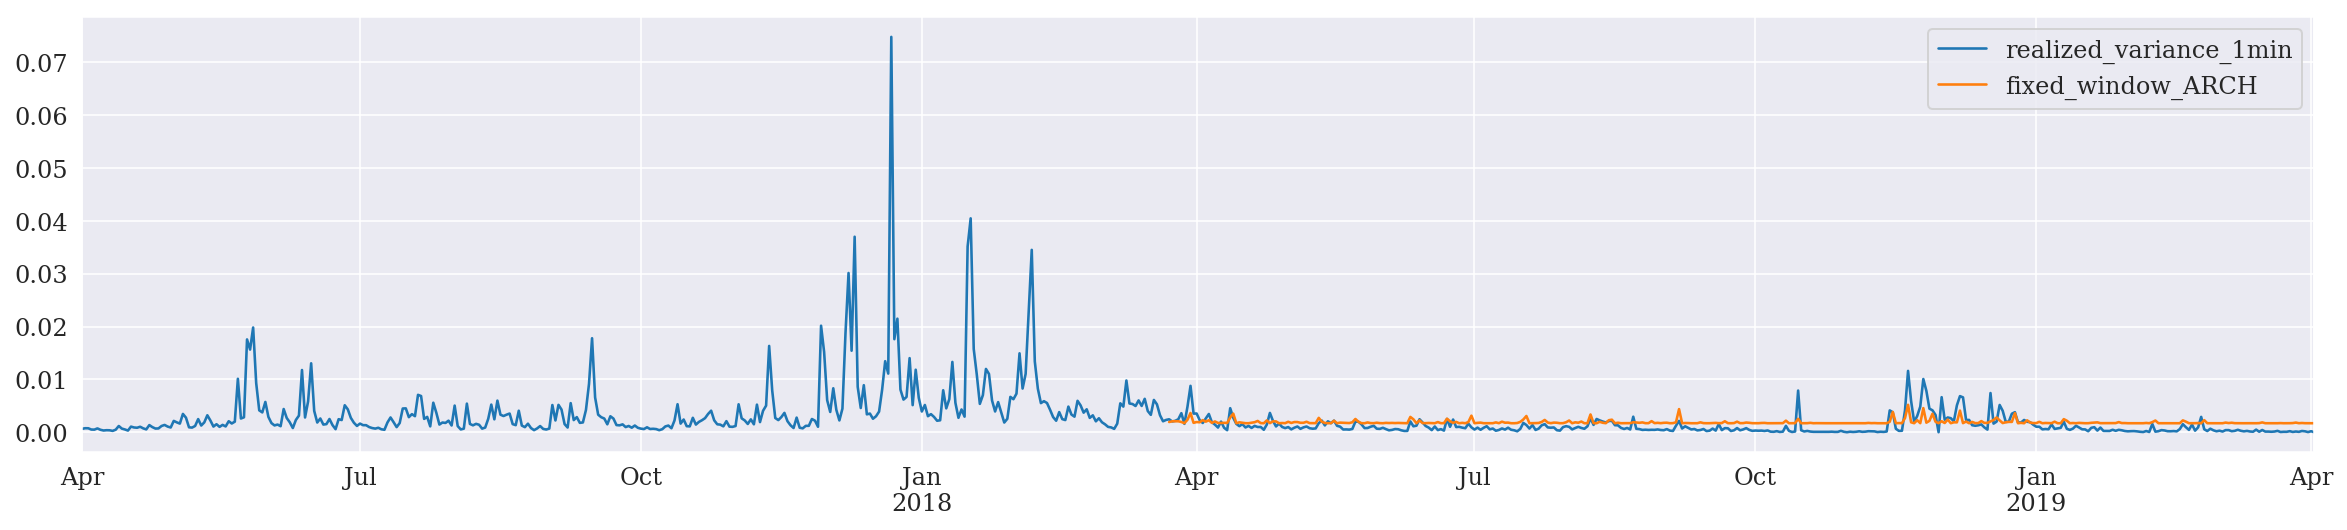

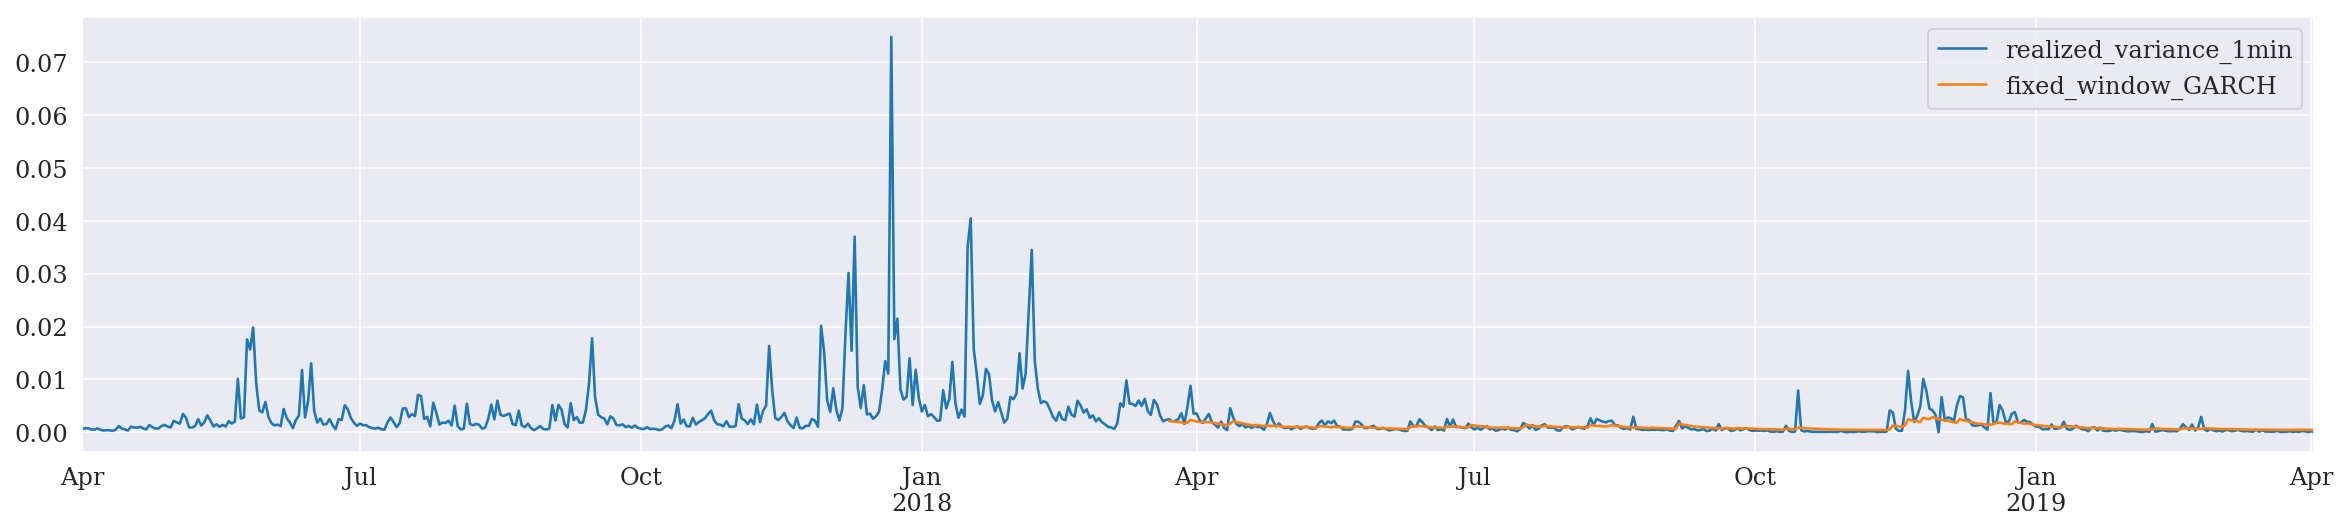

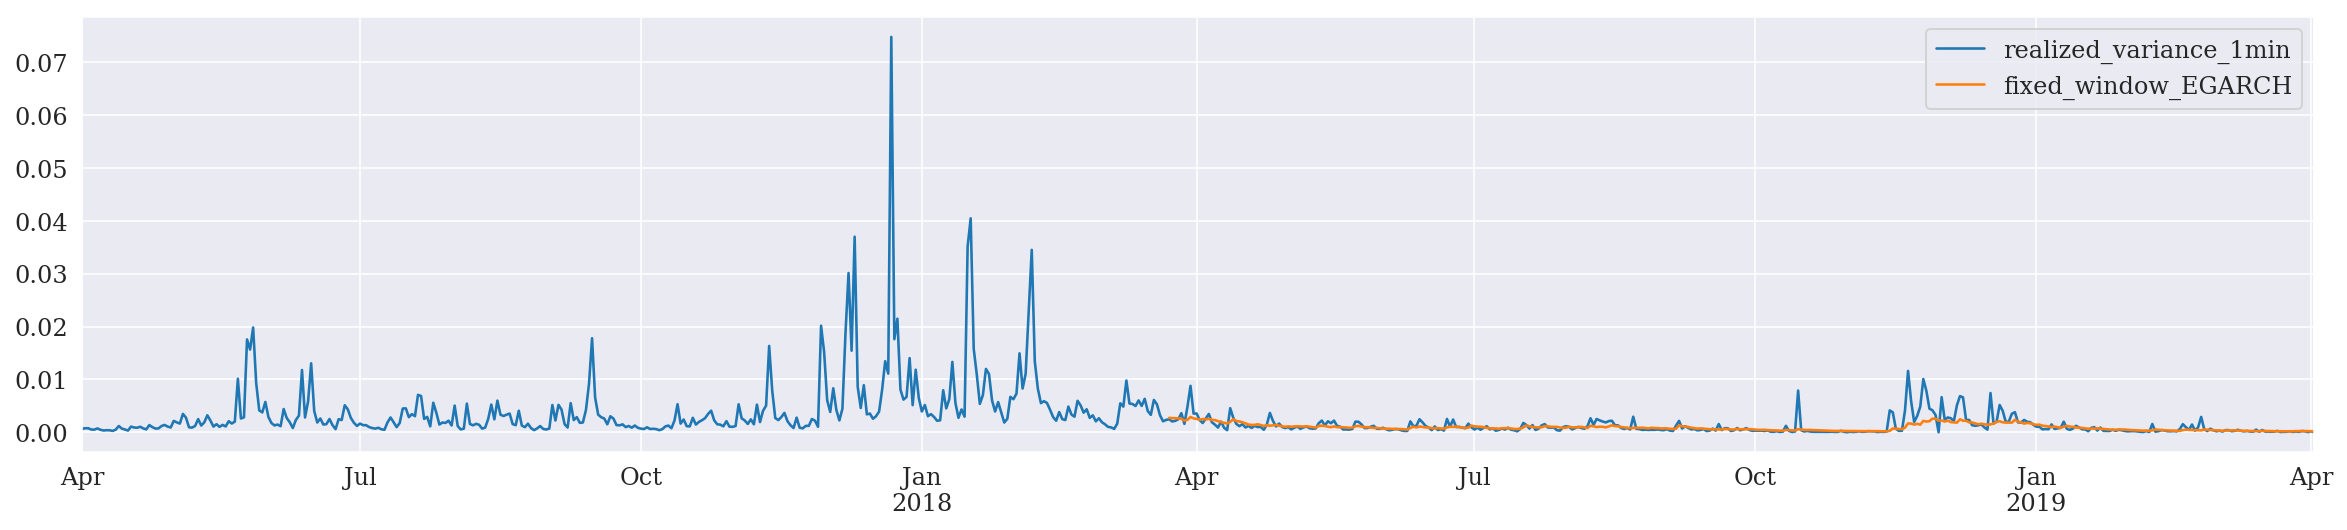

In [97]:
fixed_window_forecast(d_df)

#### Rolling Window Forecasting
In addition, we can also adopt a rolling window scheme and check if there is any improvement.
> Rolling window forecasts use a fixed sample length and then produce one-step from the final observation.

Basically, the model generates one-step ahead forecast and drops the oldest daily log return while including the newest daily return for a re-fit. Similarly, we will have a simple function to run ARCH, GARCH and EGARCH all together.

In [102]:
def rolling_window_forecast(pd_dataframe):     

    # Set rolling window
    window = 365
    
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:

        index = d_df[1:].index
        end_loc = np.where(index >= d_df.index[window])[0].min()
        forecasts = {}
        for i in range(len(d_df[1:]) - window + 2):  
            mod = arch_model(pd_dataframe['log_return'][1:], mean='Zero', vol=model, dist='t')
            res = mod.fit(first_obs=i, last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
            temp = res.forecast().variance
            fcast = temp.iloc[i + end_loc - 1]
            forecasts[fcast.name] = fcast

        forecasts = pd.DataFrame(forecasts).T
        pd_dataframe['rolling_window_{}'.format(model)] = forecasts['h.1']
        
        print('------------------------------------------------')
        print('Rolling Window Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'realized_variance_1min', 'rolling_window_{}'.format(model))

------------------------------------------------
Rolling Window Forcasting ARCH
Mean Absolute Error (MAE): 0.000858
Mean Absolute Percentage Error (MAPE): 1.52e+06
Root Mean Square Error (RMSE): 0.00121
------------------------------------------------
Rolling Window Forcasting GARCH
Mean Absolute Error (MAE): 0.000616
Mean Absolute Percentage Error (MAPE): 6.41e+05
Root Mean Square Error (RMSE): 0.00117
------------------------------------------------
Rolling Window Forcasting EGARCH
Mean Absolute Error (MAE): 0.00058
Mean Absolute Percentage Error (MAPE): 3.5e+05
Root Mean Square Error (RMSE): 0.00126


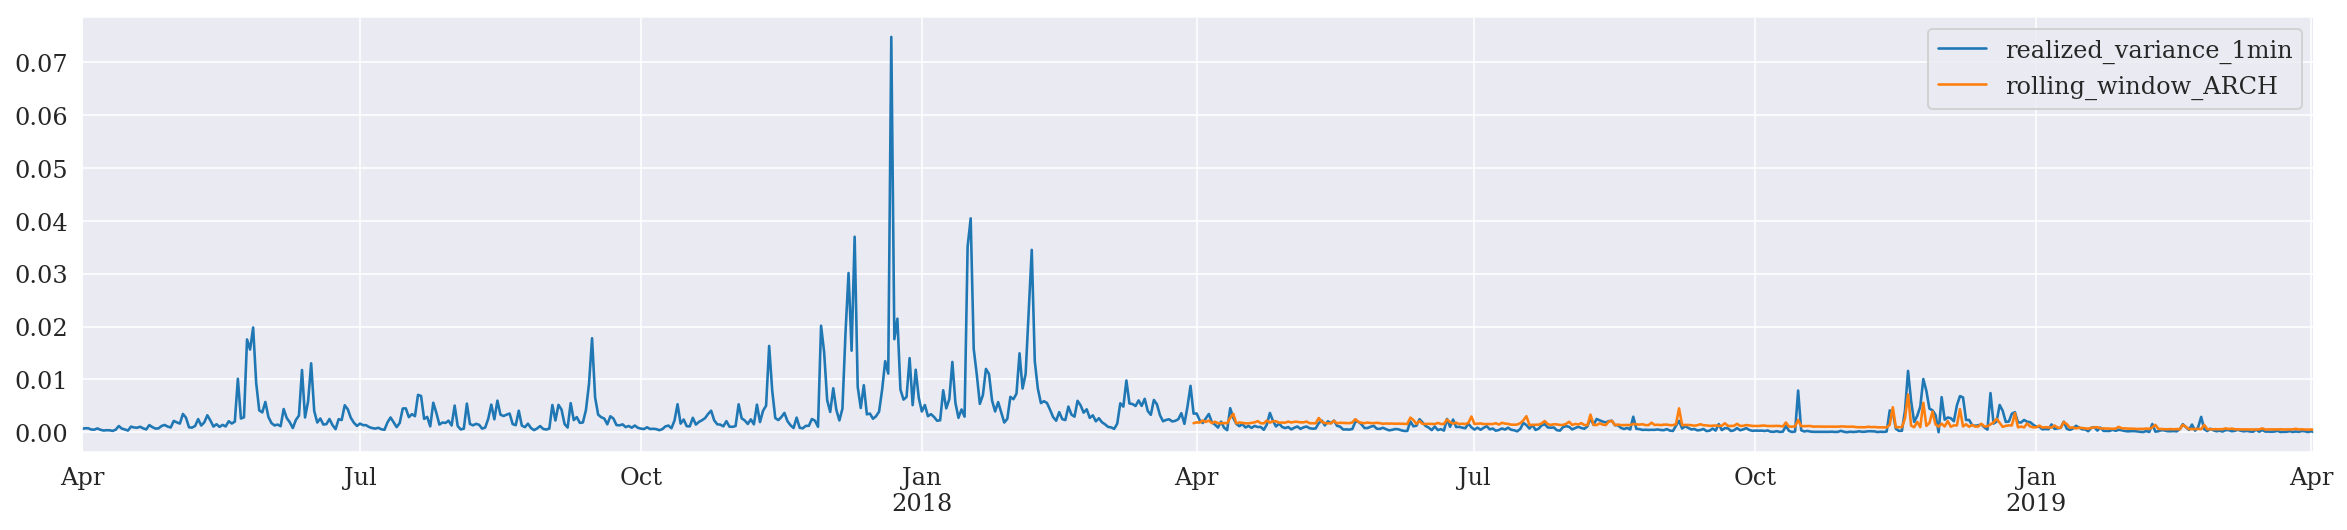

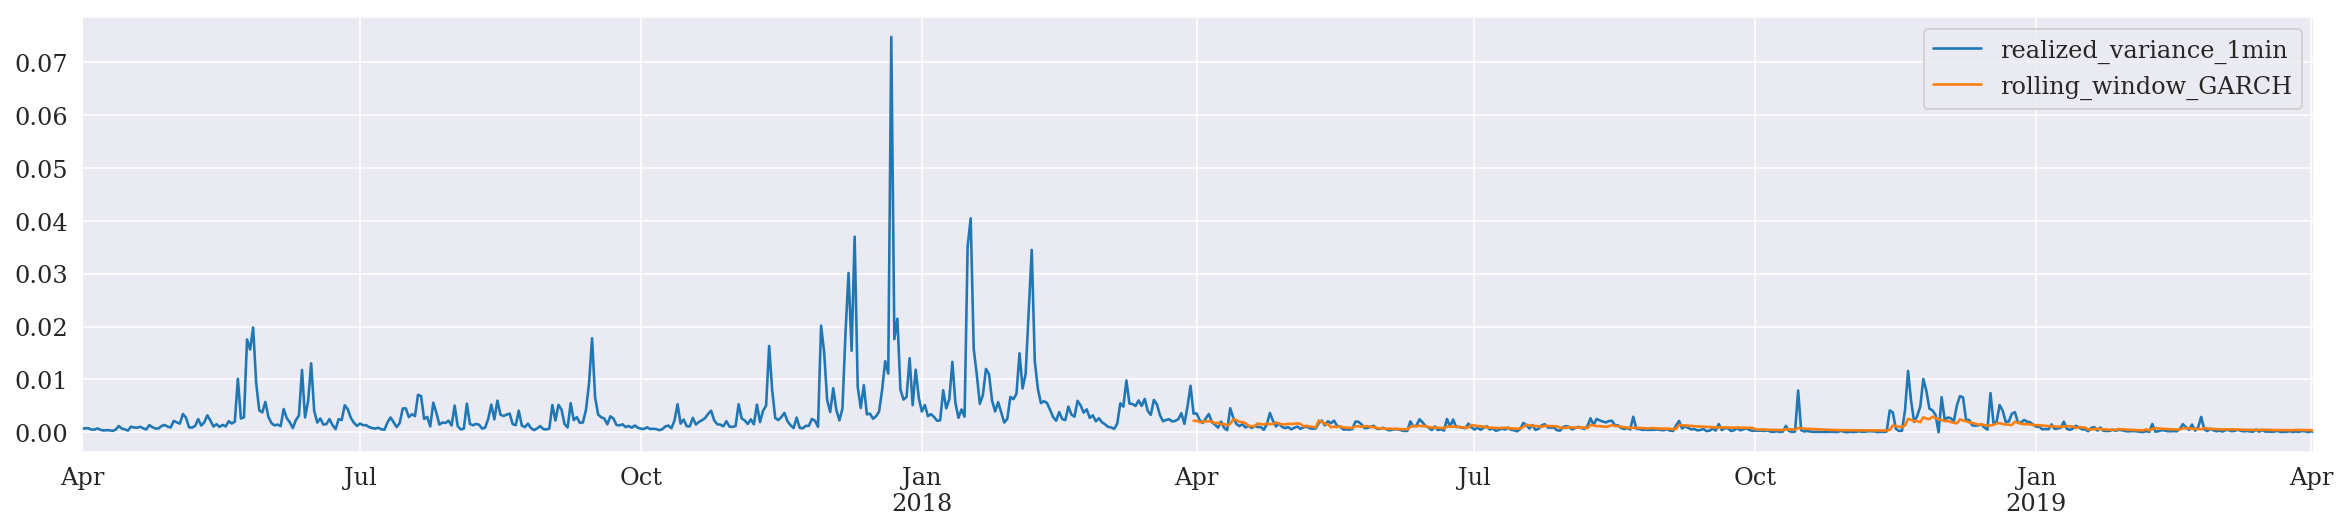

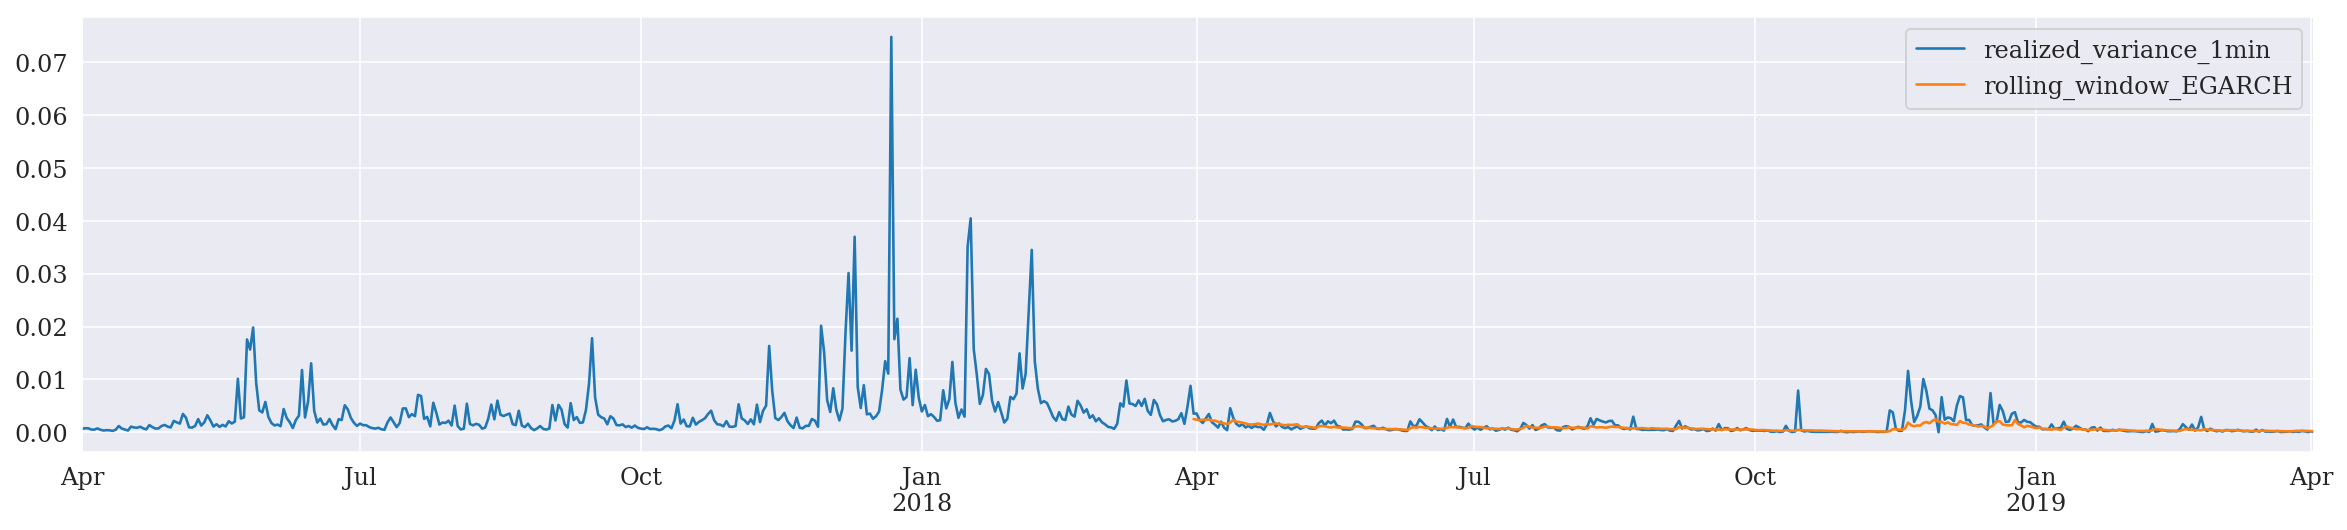

In [103]:
rolling_window_forecast(d_df)

#### Recursive Forecast Generation
There is one more forecasting scheme provided by ```ARCH``` package.
> Recursive is similar to rolling except that the initial observation doesn’t change. This can be easily implemented by dropping the ```first_obs``` input.

In [104]:
def recursive_forecast(pd_dataframe):     

    # Set rolling window
    window = 365
    
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:

        index = d_df[1:].index
        end_loc = np.where(index >= d_df.index[window])[0].min()
        forecasts = {}
        for i in range(len(d_df[1:]) - window + 2):  
            mod = arch_model(pd_dataframe['log_return'][1:], mean='Zero', vol=model, dist='t')
            res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
            temp = res.forecast().variance
            fcast = temp.iloc[i + end_loc - 1]
            forecasts[fcast.name] = fcast

        forecasts = pd.DataFrame(forecasts).T
        pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
        
        print('------------------------------------------------')
        print('Recursive Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'realized_variance_1min', 'recursive_{}'.format(model))

------------------------------------------------
Recursive Forcasting ARCH
Mean Absolute Error (MAE): 0.000867
Mean Absolute Percentage Error (MAPE): 1.69e+06
Root Mean Square Error (RMSE): 0.00121
------------------------------------------------
Recursive Forcasting GARCH
Mean Absolute Error (MAE): 0.000583
Mean Absolute Percentage Error (MAPE): 6.49e+05
Root Mean Square Error (RMSE): 0.00117
------------------------------------------------
Recursive Forcasting EGARCH
Mean Absolute Error (MAE): 0.000546
Mean Absolute Percentage Error (MAPE): 3.15e+05
Root Mean Square Error (RMSE): 0.00116


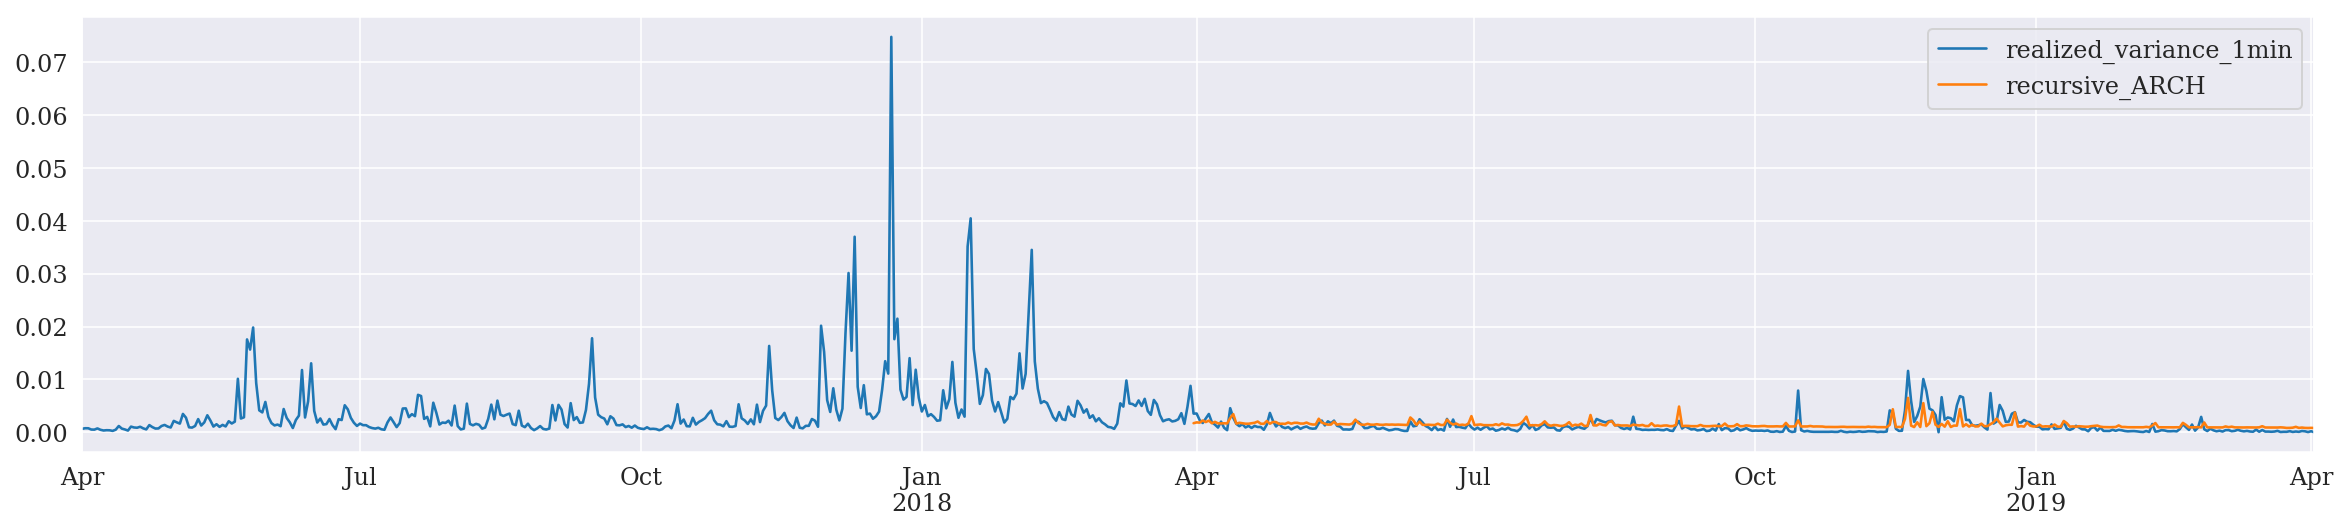

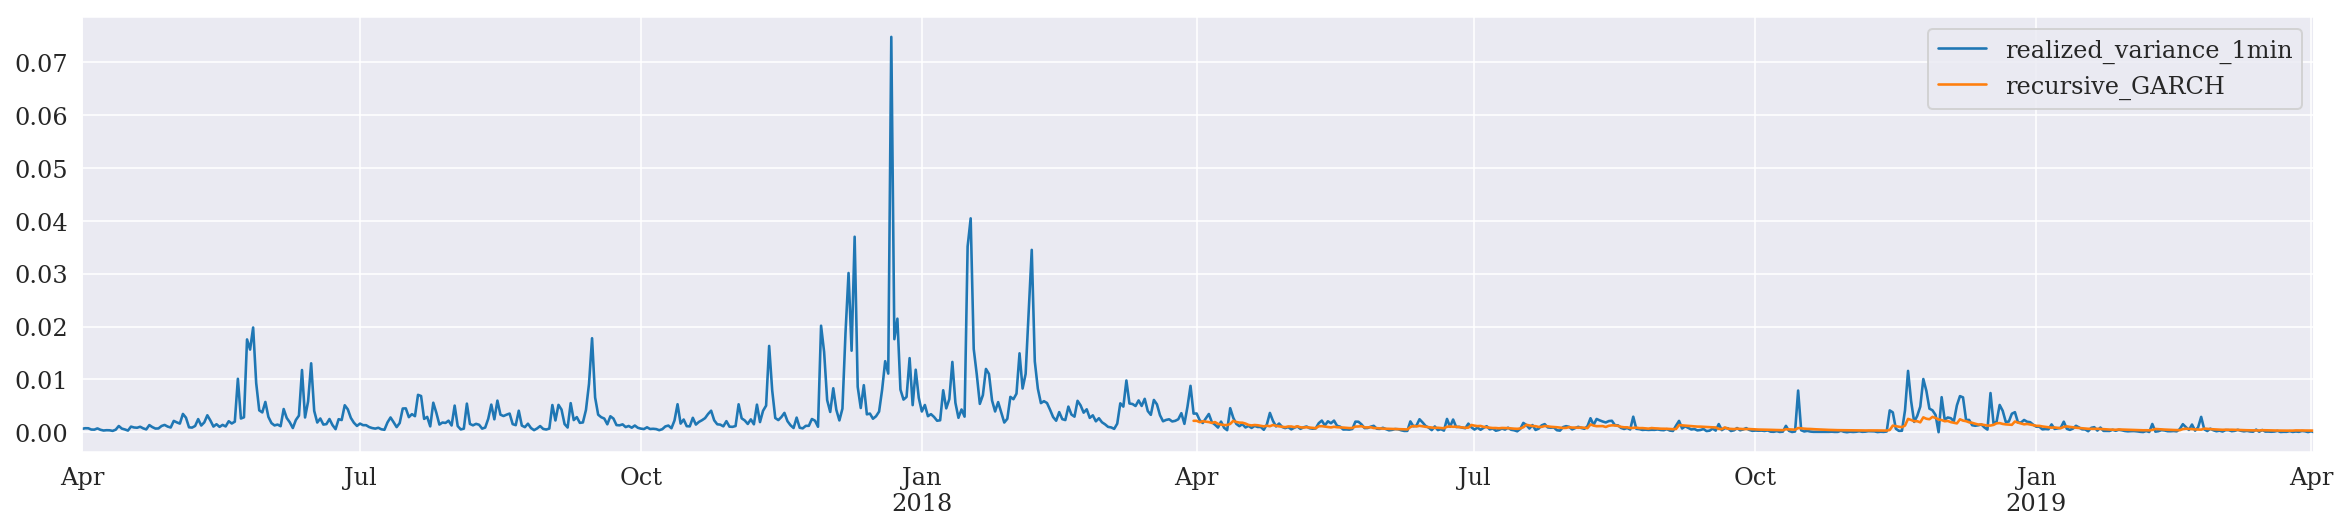

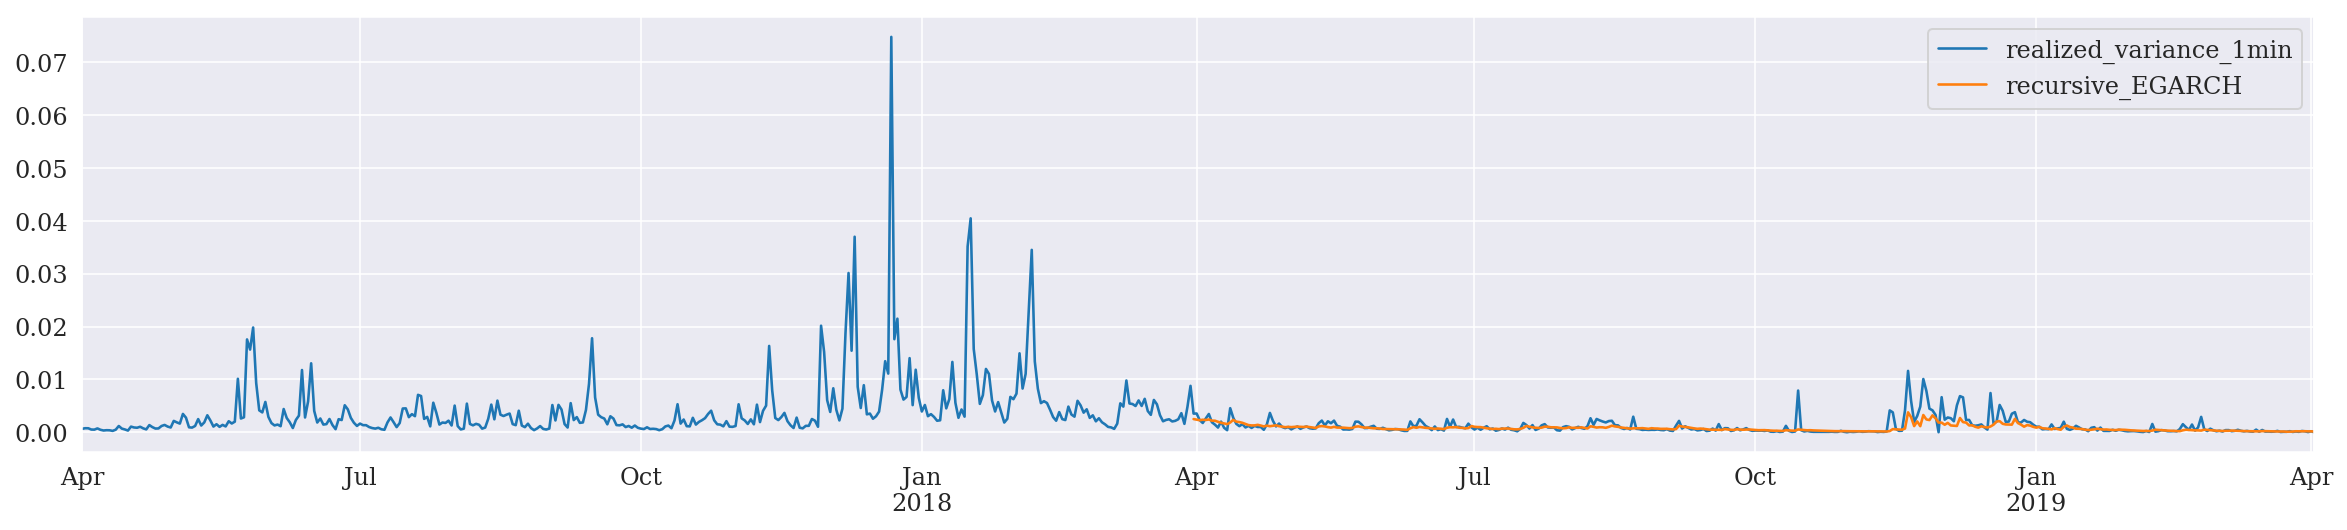

In [105]:
recursive_forecast(d_df)

EGARCH has outperformed the other two in all 3 forecasting schemes based on MAE, MAPE, and RMSE

## The End

I hope you have enjoyed this piece. My apologies for this long post. There are a couple of other directions we could have pursued further. For instance, ```simulation``` and ```bootstrap``` are two methods which could be implemented in EGARCH for out-of-sample forecasting. It would be very interesting to see the simulation paths from their results. I guess those exciting challenges will be left to our readers who are eager to investigate further.

Again, thank you for your time and patience. All source code will be uploaded to my github. Let me know if you have any questions/comments/proposals. My contact information can be found at the beginning of this post. 

Stay calm and happy trading!